In [2]:
# Load basic dependencies:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
#import sys
import numpy as np

# Disable TensorFlow eager execution:
import tensorflow as tf
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

# Load Keras dependencies:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image

# Load ART dependencies:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import ProjectedGradientDescent
from art.attacks.evasion import PixelAttack, TargetedUniversalPerturbation
from art.defences.preprocessor import SpatialSmoothing
from art.utils import to_categorical

# Install ImageNet stubs:
!{sys.executable} -m pip install git+https://github.com/nottombrown/imagenet_stubs
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name

In [3]:
images_list = list()
for i, image_path in enumerate(imagenet_stubs.get_image_paths()):
    im = image.load_img(image_path, target_size=(224, 224))
    im = image.img_to_array(im)
    images_list.append(im)
    if 'unicycle.jpg' in image_path:
        # get unicycle index
        unicycle_idx = i
images = np.array(images_list)

In [4]:
print('Number of images:', images.shape[0])
print('Dimension of images:', images.shape[1], 'x', images.shape[2], 'pixels')
print('Number of color channels:', images.shape[3], '(RGB)')

Number of images: 16
Dimension of images: 224 x 224 pixels
Number of color channels: 3 (RGB)


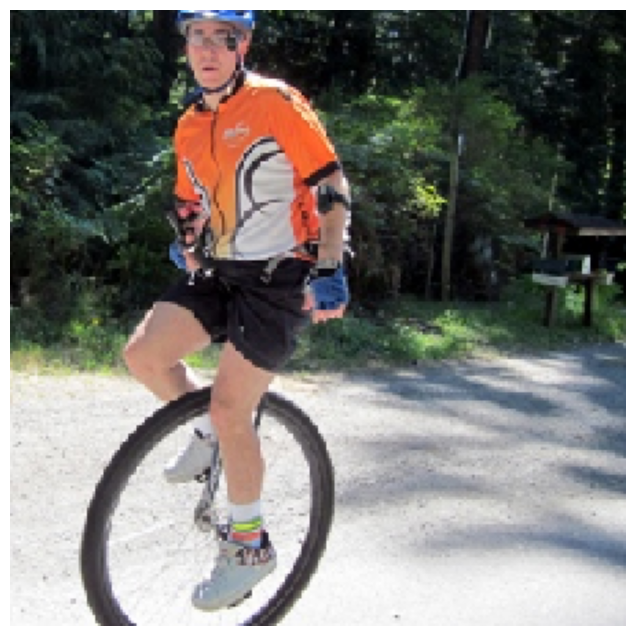

In [5]:
idx = unicycle_idx

plt.figure(figsize=(8,8)); plt.imshow(images[idx] / 255); plt.axis('off'); plt.show()

In [6]:
for i in range(1000):
    print('label', i, '-', label_to_name(i))

label 0 - tench, Tinca tinca
label 1 - goldfish, Carassius auratus
label 2 - great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
label 3 - tiger shark, Galeocerdo cuvieri
label 4 - hammerhead, hammerhead shark
label 5 - electric ray, crampfish, numbfish, torpedo
label 6 - stingray
label 7 - cock
label 8 - hen
label 9 - ostrich, Struthio camelus
label 10 - brambling, Fringilla montifringilla
label 11 - goldfinch, Carduelis carduelis
label 12 - house finch, linnet, Carpodacus mexicanus
label 13 - junco, snowbird
label 14 - indigo bunting, indigo finch, indigo bird, Passerina cyanea
label 15 - robin, American robin, Turdus migratorius
label 16 - bulbul
label 17 - jay
label 18 - magpie
label 19 - chickadee
label 20 - water ouzel, dipper
label 21 - kite
label 22 - bald eagle, American eagle, Haliaeetus leucocephalus
label 23 - vulture
label 24 - great grey owl, great gray owl, Strix nebulosa
label 25 - European fire salamander, Salamandra salamandra
label 26 

In [7]:
target_label = 94

In [8]:
x_art = np.expand_dims(images[idx], axis=0)

In [9]:
model = ResNet50(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


2023-02-17 22:06:25.722901: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-02-17 22:06:25.973101: W tensorflow/c/c_api.cc:291] Operation '{name:'conv5_block2_3_bn/beta/Assign' id:3626 op device:{requested: '', assigned: ''} def:{{{node conv5_block2_3_bn/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv5_block2_3_bn/beta, conv5_block2_3_bn/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [10]:
class BetterClassifier(KerasClassifier):
        
    def predict(
        self, x: np.ndarray, batch_size: int = 128, training_mode: bool = False, **kwargs
    ) -> np.ndarray:
        """
        Perform prediction for a batch of inputs.

        :param x: Input samples.
        :param batch_size: Size of batches.
        :param training_mode: `True` for model set to training mode and `'False` for model set to evaluation mode.
        :return: Array of predictions of shape `(nb_inputs, nb_classes)`.
        """
        # Apply preprocessing
        x_preprocessed, _ = self._apply_preprocessing(x, y=None, fit=False)

        # Create containers for our predictions and spatial smoothening window sizes
        prediction_labels=[]
        prediction_scores=[]
        label_counts={}
        smoothening_values=[np.random.randint(1,8) for i in range(10)]
        
        #Predict with each window size, and store the labels and prediction scores in their containers
        for i in smoothening_values:
            sss = SpatialSmoothing(window_size=i)
            x_def,_ = sss(x_preprocessed)
            pred = self._model.predict(x_def,batch_size=batch_size)
            label = label_to_name(np.argmax(pred, axis=1)[0])
            prediction_scores.append(pred)
            prediction_labels.append(label)
        
        #finding out which label is most frequently identified, and taking a weighted mean of that label's scores
        for label in prediction_labels:
            if label in label_counts:
                label_counts[label] += 1
            else:
                label_counts[label] = 1
                
        most_frequent_label = max(label_counts, key=label_counts.get)
        most_frequent_indexes = [i for i, p in enumerate(prediction_labels) if p == most_frequent_label]
        most_frequent_pred_scores = [prediction_scores[i] for i in most_frequent_indexes]

        weights = 1/np.array([smoothening_values[i] for i in most_frequent_indexes])
        predictions = np.average(most_frequent_pred_scores,axis=0,weights=weights)
        
        # Apply postprocessing
        predictions = self._apply_postprocessing(preds=predictions, fit=False)

        return predictions

In [11]:
betterclassifier = BetterClassifier(model,clip_values=(0, 255))

Keras model has no loss set. Classifier tries to use `k.sparse_categorical_crossentropy`.


In [12]:
def predictimage(x):
    pred = betterclassifier.predict(x)
    label = np.argmax(pred, axis=1)[0]
    confidence = pred[:,label][0]

    print('Prediction:', label_to_name(label), '- confidence {0:.2f}'.format(confidence))

In [13]:
predictimage(x_art)

2023-02-17 22:06:58.447432: W tensorflow/c/c_api.cc:291] Operation '{name:'predictions/Softmax' id:3922 op device:{requested: '', assigned: ''} def:{{{node predictions/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](predictions/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Prediction: unicycle, monocycle - confidence 0.93


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

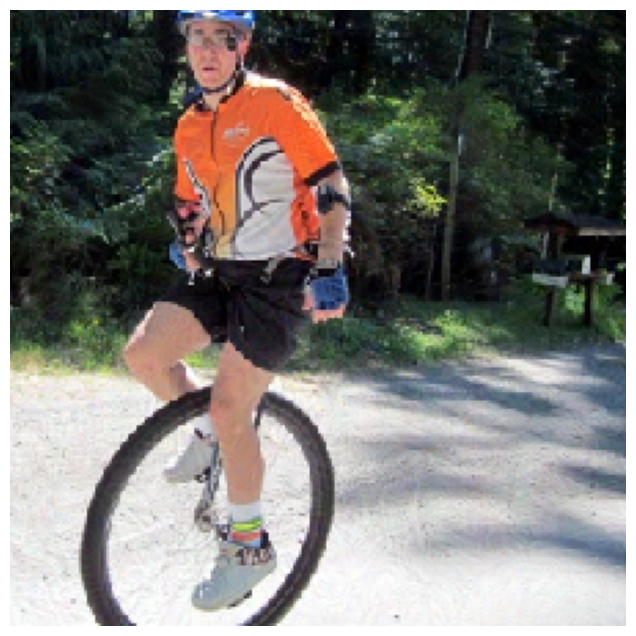

Prediction: unicycle, monocycle - confidence 0.91


In [16]:
# Create the attacker:
adv = ProjectedGradientDescent(betterclassifier, targeted=False, max_iter=10, eps_step=1, eps=5)

# Generate the adversarial sample:
x_art_adv = adv.generate(x_art)

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv[0] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
predictimage(x_art_adv)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

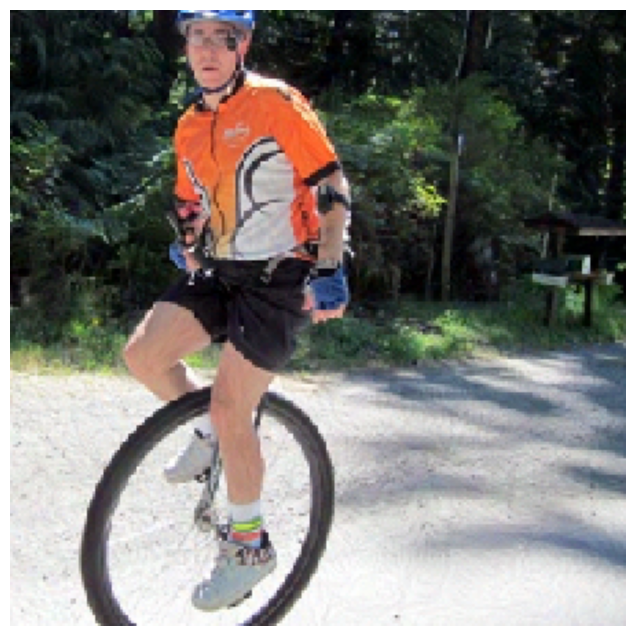

Prediction: unicycle, monocycle - confidence 0.99


In [17]:
# Set the configuration to a targeted attack:
adv.set_params(targeted=True)

# Generate the adversarial sample:
x_art_adv = adv.generate(x_art, y=to_categorical([target_label]))

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv[0] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
predictimage(x_art_adv)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

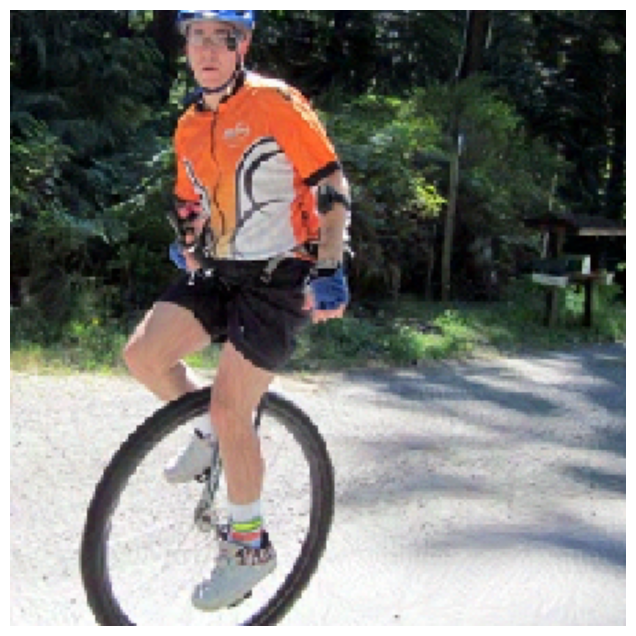

Prediction: unicycle, monocycle - confidence 0.96


In [18]:
# Create the attacker.
# Note: here we use a larger number of iterations to achieve the same level of confidence in the misclassification
adv_def = ProjectedGradientDescent(betterclassifier, targeted=True, max_iter=40, eps_step=1, eps=5)

# Generate the adversarial sample:
x_art_adv_def = adv_def.generate(x_art, y=to_categorical([target_label]))

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
predictimage(x_art_adv_def)